# Modeling overview
In this notebook we describe the models used in the numerical example of

[1] Nicole Aretz, Max Gunzburger, Mathieu Morlingham, Karen Willcox: Multifidelity Uncertainty Quantification for Ice Sheet Simulations. (submitted 2024)

Since their simulation takes quite some time, especially for the high-fidelity model, and requires the installation of ISSM, we are working with precomputed samples below, specifically the Latin Hypercube samples that were used in our paper [1].

The goals of this notebook is to:
1. Explain the different models used in our multifidelity setup;
2. show the uncertainty in their predictions;
3. evaluate the model covariance matrix that gets used in the multifidelity UQ methods.

## Imports

In [1]:
## Imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, RegularGridInterpolator
from scipy.optimize import curve_fit
import time
tStart_notebook = time.time()
import scipy.linalg as la
from scipy.io import loadmat
import matplotlib as mpl
import pandas as pd
import seaborn as sns

## High-fidelity model
Our high-fidelity model is run in ISSM. The code for it is described in the folder `ISSM-models`. It uses our finest mesh of Greenland (102,275 Dofs / variable), computes the ice velocity with the HO-equation, the ice temperature with the thermal model, and the ice thickness with the ice thickness equations. The equations and forcing terms are described in [1].

We have chosen 32 samples of the geothermal heat flux and basal friction field, and evaluated the high-fidelity model for these samples. In the code box below, we load in the obtained predictions:

In [2]:
filename = 'data/pilot_HOfine'
with open(filename, "rb") as file:
    predictions_hf, costs_hf, parameters = pickle.load(file)

The variable `parameters` contains the 32 sampled parameters, `costs_hf` the CPU-time for each prediction in CPU-h. We choose the average cost over these samples as our high-fidelity model cost (c.f. Table 1):

In [3]:
np.mean(costs_hf)

64.88840494869484

We are evaluating the ice mass loss relative to a control run. Moreover, we have computed the prediction at the parametric mean, and ran 480 MC samples. The next code block loads all of this information.

In [4]:
filename = 'data/control_HOfine'
with open(filename, "rb") as file:
    [output_control] = pickle.load(file)
    
filename = 'data/mean_HOfine'
with open(filename, "rb") as file:
    [output_mean] = pickle.load(file)
    
filename = 'data/MCref_HOfine'
with open(filename, "rb") as file:
    [outputs_mc] = pickle.load(file)

The MC approximation over the 480 samples is the mean:

In [5]:
output_mc = np.mean(outputs_mc, axis=0)

We next plot the predictions (relative to the control run):

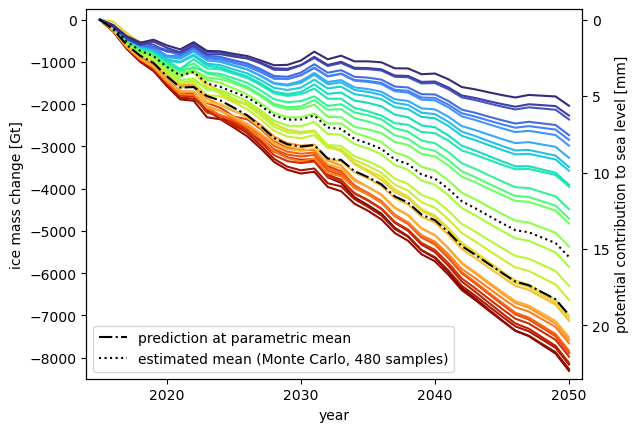

In [6]:
# order the predictions by ice mass loss at t=2050
my_order = np.argsort(predictions_hf[:, -1])
cmap = mpl.colormaps['turbo']
colors = cmap(np.linspace(0, 1, 33))[::-1]

# initialize plot
fig, ax = plt.subplots(1,1)

# plot each prediction
for j in range(32):
    ax.plot(np.arange(2015, 2051), 
            np.hstack([0, predictions_hf[my_order[j], :]-output_control]), 
            color = colors[j])
    
# plot prediction at parametric mean (NOT mean prediction)
ax.plot(np.arange(2015, 2051), np.hstack([0, output_mean-output_control]), 
        color = 'k', linestyle = "-.", label="prediction at parametric mean")

# plot MC approximation of the mean prediction
ax.plot(np.arange(2015, 2051), np.hstack([0, output_mc-output_control]), 
        color = 'k', linestyle = ":", label="estimated mean (Monte Carlo, 480 samples)")
    
# set labels
ax.set_xlabel("year")
ax.set_ylabel("ice mass change [Gt]")

# set axis limits and ticks
ax.set_ylim(-8500, 250)
ax.set_xlim(2014, 2051)
ax.set_xticks([2020, 2030, 2040, 2050], [2020, 2030, 2040, 2050])

# convert to mm SLR for axis on the right side of the plot
ax2 = ax.twinx()
ax2.set_ylim((ax.get_ylim()[0] / -361.8, ax.get_ylim()[1] / -361.8))
ax2.set_ylabel("potential contribution to sea level [mm]")

# legend
ax.legend()

Some remarks about this plot:
- We have color-coded the predictions based on the final ice mass loss observed in the year 2050. In other plots, we use the same color-code, i.e. the color of a prediction at a parameter is the same, even if the prediction is made with a different model.
- The dashed-dotted line is the prediction at the parametric mean, _not_ the mean prediction. 
- The files contain the Greenland ice mass [Gt] for the years 2016, ..., 2050 computed for the different parameters. In the year 2015, the ice mass is the same for both all predictions and the control run (since it is the ice mass of the initial condition). That's why for t=2015 we can set the ice mass loss to 0.

## Other ISSM models

The other models run exclusively in ISSM have a coarser mesh than the high-fidelity model, or use the SSA solver for the velocity to speed things up (or both). The box below loads their predictions at the pilot samples.

In [7]:
pilot_outputs = np.zeros(13, dtype=object)
mean_costs = np.zeros(13)

# high-fidelity
pilot_outputs[0] = predictions_hf
mean_costs[0] = np.mean(costs_hf)

# HO, medium mesh
filename = 'data/pilot_HOmedium'
with open(filename, "rb") as file:
    pilot_outputs[2], costs, __ = pickle.load(file)
mean_costs[2] = np.mean(costs)

# HO, coarse mesh
filename = 'data/pilot_HOcoarse'
with open(filename, "rb") as file:
    pilot_outputs[4], costs, __ = pickle.load(file)
mean_costs[4] = np.mean(costs)

# SSA, fine mesh
filename = 'data/pilot_SSAfine'
with open(filename, "rb") as file:
    pilot_outputs[6], costs, parameters_SSA = pickle.load(file)
mean_costs[6] = np.mean(costs)

# SSA, medium mesh
filename = 'data/pilot_SSAmedium'
with open(filename, "rb") as file:
    pilot_outputs[8], costs, __ = pickle.load(file)
mean_costs[8] = np.mean(costs)

# SSA, coarse mesh
filename = 'data/pilot_SSAcoarse'
with open(filename, "rb") as file:
    pilot_outputs[10], costs, __ = pickle.load(file)
mean_costs[10] = np.mean(costs)

Note that for the SSA models we evaluated predictions at 128 samples since they are a lot cheaper and it is generally better to have a more accurate approximation of the model covariance matrix. The first 32 parameters are the same as for the HO models.

## Interpolation model

For the interpolation model, we have evaluated the ISSM model (SSA, coarse mesh) for 9 parameters on a 3x3 grid for the first two modes of the basal friction field. Those are the most important modes for the basal friction.

In [8]:
with open('data/interpolation', "rb") as input_file:
    a, b, data, xg, yg, interpolants, parameters_inter = pickle.load(input_file)

We fit a linear interpolation model to this data:

In [9]:
## setup model
interp = RegularGridInterpolator((a, b), data, fill_value=None, method="linear", bounds_error=False)

To prepare for evaluating the correlation with the other models, we evaluate the interpolation model at the same 128 parameters as the ISSM-SSA models.

In [10]:
## generate samples for computing the covariance matrix
outputs_inter = np.zeros((parameters_SSA.shape[0], 35))
for i in range(parameters_SSA.shape[0]):
    para = parameters_SSA[i, :]
    outputs_inter[i, :] = interp((para[1], para[2]))
    
pilot_outputs[12] = outputs_inter

Since estimating the variance of the model is important and the interpolation is very cheap, we evaluate it using 100000 samples. This also lets us time how long the model takes:

In [11]:
## estimate model mean (lots of samples)
n_samples = 100000
outputs_inter_2 = np.zeros((35, n_samples))
np.random.seed(seed=999)

cov = 1e+4 * np.diag([3.799730239349106, 
                      0.134732961409172, 
                      0.084822824594389, 
                      0.047563276921201, 
                      0.036720118418622, 
                      0.031001373705202, 
                      0.023955775566517])

tStart = time.time()
for i in range(n_samples):
    para = np.random.multivariate_normal(mean=np.zeros((7,)), cov=cov)
    outputs_inter_2[:, i] = interp((para[0], para[1]))
cost_interpolation = (time.time() - tStart) / n_samples

mean_interpolation = np.mean(outputs_inter_2, axis = 1)
var_interpolation = np.var(outputs_inter_2, axis = 1)

The average cost for the interpolation is very fast, below 1ms on the computer here on average. However, we did spend some time computing the training data, and the multifidelity methods do have some overhead. To make up for that, we approximate it with 10 ms instead:

In [12]:
mean_costs[12] = 0.01 / (60*60) # convert to CPU-h

## Extrapolation models

For the extrapolation model, we compute the yearly diviations from the linear curve starting at the first prediction of the reference samples to the last. This gives us the extrapolation yearly adjustment data.

In [13]:
## generate adjustment data
stacked_interp = np.vstack(interpolants)
grid_t = np.arange(0, 35, 1)

stop = 35
test = np.zeros(stacked_interp.shape)
for i in range(9):
    val_start = stacked_interp[i, 0]
    val_stop = stacked_interp[i, stop-1]
    test[i, :] = val_start + (val_stop - val_start) * grid_t/(stop-1)

diff = stacked_interp - test
adjustment = np.mean(diff, axis=0)

For the extrapolation model, we fit a model of the form
$$
f(t) = a + b*t + c*t^2 + d*<adjustment>
$$
to the first 20 years of the ISSM model predictions, with t being the number of years past 2015.

In [14]:
for ell, m in enumerate([0, 2, 4, 6, 8, 10]):
    
    x = np.arange(0, 35, 1, dtype=int)
    outputs = pilot_outputs[m]
    
    output_extrapolation = np.zeros((outputs.shape[0], 35))
    costs_extrapolation = np.zeros(outputs.shape[0])

    stop = 20

    def func(x, a, b, c, d):
        stop = 20
        x_int = np.arange(0, x.shape[0], 1, dtype=int)
        return a + (b - a) * x/(stop-1) + d * (x**2) + c*adjustment[x_int]

    for j in range(outputs.shape[0]):

        ydata = outputs[j, :]
        popt, pcov = curve_fit(func, x[:stop], ydata[:stop])
        output_extrapolation[j,:] = func(x, *popt)

    pilot_outputs[m+1] = output_extrapolation
    mean_costs[m+1] = (stop/35)*mean_costs[m]

Since the cost of the ISSM model dominates, we take (20/35) times the ISSM model cost as the cost for the extrapolation model.

## Covariance

To compute the model covariance, we first use the 32 samples only:

In [15]:
covariance = np.zeros(35, dtype = object)

for j in range(35):
    stacked = np.vstack([pilot_outputs[i][:32, j] for i in range(13)])
    covariance[j] = np.cov(stacked)

For those models where we have 128 parameters available, we replace the computed entries with those obtained from more samples:

In [16]:
for j in range(35):
    stacked = np.vstack([pilot_outputs[i][:128, j] for i in range(6, 13)])
    covariance_sub = np.cov(stacked)
    covariance[j][6:, 6:] = covariance_sub

And finally we replace the entry for the interpolation model by that computed over the 100000 samples:

In [17]:
for j in range(35):
    covariance[j][-1, -1] = var_interpolation[j]

The array `covariance` has, at index `j`, the model covariance matrix for the predictions at `j+1` years after the year 2015.

Since the values in the covariance are rather large, which can cause numerical issues in the sample size selection, we rescale it:

In [18]:
# rescaling
scaling = np.max(covariance[-1])
covariance = covariance / scaling
rescaling = np.sqrt(scaling) # to go to std dev instead of variance

## Correlation

The MFMC method needs the correlation between the different models (well, specifically the correlation of the high-fidelity model with all other models)

In [19]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [20]:
correlation = np.zeros(35, dtype=object)
for k in range(35):
    correlation[k] = correlation_from_covariance(covariance[k])

## Level variance

The MLMC method needs the variance of the levels. This is what we are computing here:

In [21]:
# MLMC input
dV = np.zeros(35, dtype=object)
for k in range(35):
    dV[k] = np.nan*np.ones_like(covariance[k])
    for i in range(13):
        for j in range(i+1,13):
            dV[k][i,j] = covariance[k][i,i] + covariance[k][j,j] - 2*covariance[k][i,j]

## Save

The surrogate models and the covariance matrices are the main ingredients for multifidelity UQ. We have saved the covariance matrix in a file:

In [22]:
# save the model covariance data

# filename = 'results/covariance'
# with open(filename, "wb") as input_file:
#     pickle.dump([covariance, correlation, dV, rescaling, mean_costs], input_file)

The code is commented out so that the user doesn't accidentally overwrite the covariance we used in our numerical examples.

## The End.

In [23]:
print("Runtime of this notebook: {} min".format((time.time()-tStart_notebook)/60))

Runtime of this notebook: 0.31340547402699787 min
